<a href="https://colab.research.google.com/github/antonio2uofa/BiT-AMO/blob/main/PID_Simulation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import time
from typing import List, Tuple
from math import sqrt

CSV_PATH = "./saved_data.csv"

"""
Class that stores the state space representation
"""
class Environment:

  def __init__(self, x_0: int = 10):
    self.x_prime: int = 0
    self.x_0: int = x_0
    self.x_t: int = x_0
    self.y: int = 0
    self.A: int = 1
    self.B: int = 1
    self.C: int = 1

  def reset(self) -> int:
    self.x_t = self.x_0
    return self.x_t

  def step(self, u) -> Tuple[int, int]:
    self.x_prime = (self.A * self.x_t)  + (self.B * u)
    self.y_prime = self.C * self.x_prime
    self.x_t = self.x_prime
    return self.x_prime, self.y_prime

"""
Class used to plot two vertical sublots of the data.
"""
class Plotter:

  def __init__(self, path: str = CSV_PATH):
    self.path: str = path
    self.x_list: List[float] = []
    self.y_list: List[float] = []
    self.u_list: List[float] = []
    self.time_list: List[float] = []
    self.SP_list: List[float] = []

  
  def plot_double(self):
    with open(self.path, 'r') as file:
      csvreader = csv.reader(file)
      for row in csvreader:
        self.x_list.append(float(row[0]))
        self.y_list.append(float(row[1]))
        self.u_list.append(float(row[2]))
        self.time_list.append(float(row[3]))
        self.SP_list.append(float(row[4]))
    
    fig, axs = plt.subplots(2, sharex='all', figsize=(12, 7))  # OD
    fig.suptitle('Y and U Plots')

    for subplt in axs:
      subplt.xaxis.set_major_formatter(plt.FormatStrFormatter('% .2f'))
      subplt.yaxis.set_major_formatter(plt.FormatStrFormatter('% .2f'))

    axs[0].plot(self.time_list, self.x_list, self.time_list, self.SP_list)
    axs[1].plot(self.time_list, self.u_list)
    axs[1].set_xlabel('Time (s)') #OD
    axs[1].set_ylabel('Level (%)') #OD
    axs[0].set_ylabel('Fan Speed (rpm)') #OD

"""
Super Class used to initialize variables in both PID methods and contains
their reset functions.
"""
class PID:
  def __init__(self, Kc: float, time_I: float, time_D: float, bias: float, sat_max: float, sat_min: float):
    self.Kc = Kc
    self.time_I = time_I
    self.time_D = time_D
    self.bias = bias
    self.sat_max = sat_max
    self.sat_min = sat_min

    self.err_k: float = 0.0
    self.err_k_min1: float = 0.0
    self.err_sum: float = 0.0

    self.y_m_k: float = 0.0
    self.y_m_k_min1: float = 0.0
    self.y_m_k_min2: float = 0.0

    self.P: float = 0.0
    self.I: float = 0.0
    self.D: float = 0.0
    self.p_k: float = 0.0
    
    self.k: int = 1
    self.saturated: bool = False
  
  def reset(self):
    self.k = 1
    self.err_sum = 0

"""
Derived class of PID class. Uses the position PID method and elimination of derivative
kick method described in Seborg Chapter 8. Commented out code is to be implemented
either when using error calculations or to implement pausing of error calculation
when saturated.
"""
class PostitionForm(PID):
  def __init__(self, Kc: float = 1.0, time_I: float = 1.0, time_D: float = 5.0,
               bias: float = 1.0, sat_max: float = 100.0, sat_min: float = -100.0):

    super().__init__(Kc, time_I, time_D, bias, sat_max, sat_min)

  def step(self, measured_val: float, set_point: float, period: float) -> float:
    self.y_m_k = measured_val

    if self.k > 1:  # Loop is used to store k-1 error value
      self.err_k_min1 = self.err_k
      self.y_m_k_min1 = self.y_m_k

    self.err_k = set_point - measured_val
    self.err_sum += self.err_k

    self.P = self.err_k 
    self.I = (period / self.time_I) * (self.err_sum)
    self.D = -(self.time_D / period) * (self.y_m_k - self.y_m_k_min1)

    self.p_k = self.bias + self.Kc * (self.P + self.I + self.D) # Recommended change at point k

    self.k += 1

    return self.p_k
  
  def reset(self):
    super().reset()
    
"""
Derived class of PID class. Uses the velocity PID method and elimination of derivative
kick method described in Seborg Chapter 8. Commented out code is to be implemented
either when using error calculations or to implement pausing of error calculation
when saturated.
"""
class VelocityForm(PID):
  def __init__(self, Kc: float = 1.0, time_I: float = 1.0, time_D: float = 5.0,
               bias: float = 1.0, sat_max: float = 100.0, sat_min: float = -110.0):

    super().__init__(Kc, time_I, time_D, bias, sat_max, sat_min)
    self.delta_p_k: float = 0.0
  
  def step(self, measured_val: float, set_point: float, period: float) -> Tuple[float,float]:

    self.y_m_k = measured_val

    if self.k > 2:  #Used to set k-1 error and k-1, k-2 measured value
      self.err_k_min1 = self.err_k
      self.y_m_k_min2 = self.y_m_k_min1
      self.y_m_k_min1 = self.y_m_k

    elif self.k == 2:  # Used to initialize k-1 error and k-1 measured value
      self.err_k_min1 = self.err_k
      self.y_m_k_min1 = self.y_m_k

    self.err_k = set_point - measured_val
    self.err_sum += self.err_k_min1

    # CALCULATE Delta_p_k
    self.P = self.err_k - self.err_k_min1
    self.I = (period/self.time_I) * self.err_k
    self.D = -(self.time_D/period) * (self.y_m_k - 2 * self.y_m_k_min1 + self.y_m_k_min2)
    self.delta_p_k = self.Kc * (self.P + self.I + self.D)

    self.k += 1
    return self.delta_p_k

  def reset(self):
    super().reset()

  


# **The code above is based on Chapter 8 of the Seborg textbook and the equations found within.**
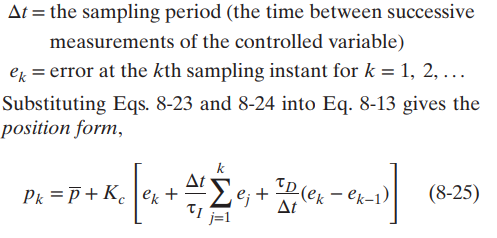

# **Formula 8-25 is used for the PID controller based on position. Whereas Formula 8-27 is used for the velocity PID controller.**




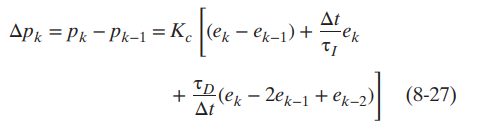

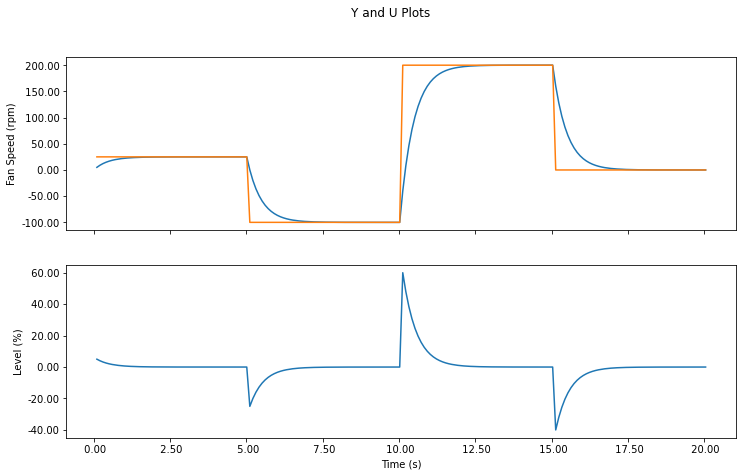

In [ ]:
"""
Initialize simulation variables and perform PID controls on them.
"""
def main():

  # Objects used to perform PID controls
  position = PostitionForm(0.2, 1000.0, 0.1, 0.0)
  environment = Environment(0)

  # Used to change set point after a number of loop iterations
  SP_list: List[float] = [25.0, -100.0, 200.0, 0.0]
  steps: int = 200 #OD
  SP_counter: int = 0

  # Used for graphing and calculations
  y: float = 0.0
  u: float = 0.0
  counter: float = 0
  period_end: float = 0.1
  period_start: float = 0.0
  curr_time: float = 0.0

  with open(CSV_PATH, 'w', newline='') as file:
      writer = csv.writer(file)

      for i in range(steps):
        setpoint: float = SP_list[SP_counter]
        sample_period: float = period_end - period_start

        period_start = time.time()
        p_k = position.step(y, setpoint, sample_period)
        x, y = environment.step(p_k)

        curr_time += sample_period
        counter += 1

        writer.writerow([x, y, p_k, curr_time, setpoint])
        time.sleep(0.1)
        period_end = time.time()
        
        # If statement updates setpoint
        if counter == 50:
          SP_counter += 1
          counter = 0
  
  plotter = Plotter()
  plotter.plot_double()



if __name__ == "__main__":
  main()


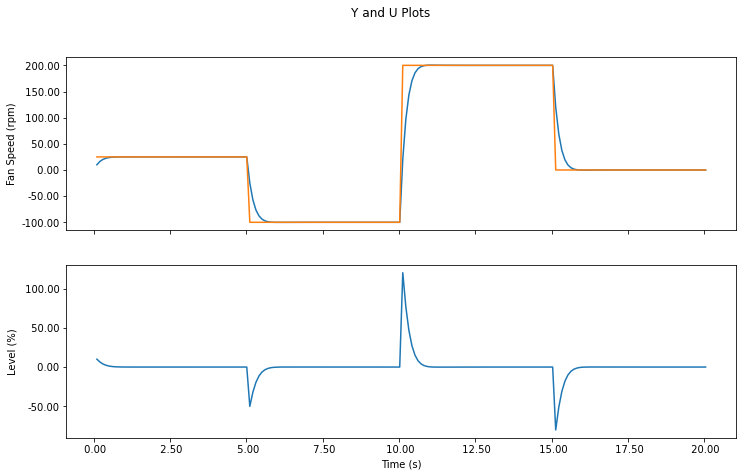

In [ ]:
"""
Initialize simulation variables and perform PID controls on them.
"""
def main():

  # Objects used to perform PID controls
  velocity = VelocityForm(0.2, 0.1, 0.27, 0.0)
  environment = Environment(0)

  # Used to change set point after a number of loop iterations
  SP_list: List[float] = [25.0, -100.0, 200.0, 0.0]
  steps: int = 200 #OD
  SP_counter: int = 0

  # Used for graphing and calculations
  y: float = 0.0
  u: float = 0.0
  counter: float = 0
  period_end: float = 0.1
  period_start: float = 0.0
  curr_time: float = 0.0

  with open(CSV_PATH, 'w', newline='') as file:
      writer = csv.writer(file)

      for i in range(steps):
        setpoint: float = SP_list[SP_counter]
        sample_period: float = period_end - period_start

        period_start = time.time()
        delta_p_k = velocity.step(y, setpoint, sample_period)
        x, y = environment.step(delta_p_k)

        curr_time += sample_period
        counter += 1

        writer.writerow([x, y, delta_p_k, curr_time, setpoint])
        time.sleep(0.1)
        period_end = time.time()
        
        # If statement updates setpoint
        if counter == 50:
          SP_counter += 1
          counter = 0
  
  plotter = Plotter()
  plotter.plot_double()



if __name__ == "__main__":
  main()